In [1]:
%env CUDA_VISIBLE_DEVICES=7
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

env: CUDA_VISIBLE_DEVICES=7


In [2]:
import copy
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate

from utils.visualization import display_image_pair
from utils.model import read_model_config, load_model
from utils.dataset import read_dataset_config, load_dataset, Preprocessor

In [3]:
analysis_type = 'combination' # 'layers', 'timesteps', 'combination'

if analysis_type == 'layers':
    model_name = 'diff_add_analysis_layers'
elif analysis_type == 'timesteps':
    model_name = 'diff_add_analysis_timesteps'
elif analysis_type == 'combination':
    model_name = 'combination_add_analysis'

dataset_config = '../dataset_config.yaml'
model_config = '../eval_config.yaml'
device_type = 'cuda'
pck_threshold = 0.1

In [4]:
# Load model config
model_config = read_model_config(model_config)[model_name]

# Get model parameters
image_size = model_config.get('image_size', (512, 512))
grad_enabled = model_config.get('grad_enabled', False)
rescale_data = model_config.get('rescale_data', False)
image_range = model_config.get('image_range', (-1, 1))

# Load model
model = load_model(model_name, model_config)

# Move model to device
device = torch.device(device_type)
model.to(device)

# Load dataset config
dataset_config = read_dataset_config(dataset_config)

# Define preprocessor
preprocess = Preprocessor(image_size, image_range=image_range, rescale_data=rescale_data)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Using cache found in /export/home/ra63des/.cache/torch/hub/facebookresearch_dinov2_main
/export/home/ra63des/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/export/home/ra63des/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/export/home/ra63des/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Evaluating dataset: SPair-71k


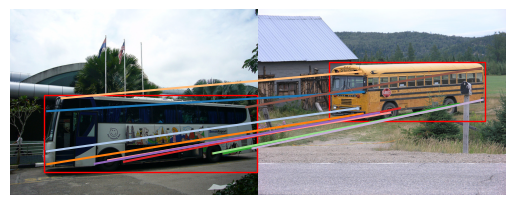

In [8]:
# Evaluate
dataset_name = list(dataset_config.keys())[0]
print(f"Evaluating dataset: {dataset_name}")
config = dataset_config[dataset_name]
dataset = load_dataset(dataset_name, config)

# Take first sample
unprocessed_sample = dataset[0]

# Use only 1 keypoint for Hedlin et al. because of time constraints
if model_name == 'hedlin':
    rand_i = torch.randint(0, unprocessed_sample['source_points'].shape[0], (1,)).item()
    unprocessed_sample['source_points'] = unprocessed_sample['source_points'][rand_i, :].unsqueeze(0)
    unprocessed_sample['target_points'] = unprocessed_sample['target_points'][rand_i, :].unsqueeze(0)

# Visualize sample
display_image_pair(unprocessed_sample, show_bbox=True)

# Preprocess sample
sample = preprocess(copy.deepcopy(unprocessed_sample))

def batchify(sample):
    batch = {}
    for key in sample:
        if key in ['source_image', 'target_image', 'source_bbox', 'target_bbox']:
            batch[key] = sample[key].unsqueeze(0)
        else:
            batch[key] = [sample[key]]
    return batch

# Batchify sample
sample = batchify(sample)

# load images on device
sample['source_image'] = sample['source_image'].to(device)
sample['target_image'] = sample['target_image'].to(device)

In [9]:
# run through model
with torch.set_grad_enabled(grad_enabled):
    source_features = model.get_features(sample['source_image'], sample['source_category'])
    target_features = model.get_features(sample['target_image'], sample['target_category'])

In [12]:
# Plot Co-PCA over different layers and timesteps

def co_pca(features, n):
    # [B, C, H, W] -> [B, n, H, W]
    b, c, h, w = features.shape
    features = features.permute(1, 0, 2, 3).reshape(c, -1).T # [B*H*W, C]
    
    U, S, V = torch.pca_lowrank(features, q=n)
    reduced = torch.matmul(features, V[:, :n])
    reduced = reduced.T.view(n, b, h, w).permute(1, 0, 2, 3)
    return reduced

reduced_features = []
for sf, tf in zip(source_features, target_features):
    concatenated = torch.cat((sf, tf), dim=0)
    reduced = co_pca(concatenated, n=3)
    reduced = (reduced - reduced.min()) / (reduced.max() - reduced.min())
    reduced_features.append(reduced)

torch.Size([2, 2048, 70, 70])


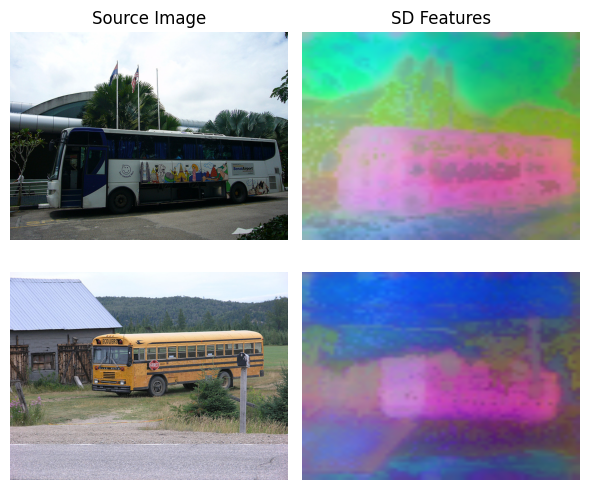

In [13]:
# Create a figure with (num_layers + 1) rows and 3 columns
interpolation_mode = 'bilinear' # 'nearest', 'bilinear'
num_layers = len(reduced_features)
fig, axes = plt.subplots(nrows=2, ncols=num_layers + 1, figsize=(3 * (num_layers + 1), 6))

# Display source and target images in the first row
axes[0, 0].imshow(unprocessed_sample['source_image'])
axes[1, 0].imshow(unprocessed_sample['target_image'])
axes[0, 0].axis('off')
axes[1, 0].axis('off')

# Set titles
axes[0, 0].set_title("Source Image")

# Loop over each layer to display the reduced features
for l, features in enumerate(reduced_features):
    source_size = unprocessed_sample['source_size'][::-1] # [H, W] -> [W, H]
    target_size = unprocessed_sample['target_size'][::-1] # [H, W] -> [W, H]
    axes[0, l+1].imshow(interpolate(features[0].unsqueeze(0), size=source_size, mode=interpolation_mode)[0].permute(1, 2, 0).cpu())
    axes[1, l+1].imshow(interpolate(features[1].unsqueeze(0), size=target_size, mode=interpolation_mode)[0].permute(1, 2, 0).cpu())
    if analysis_type == 'layers':
        axes[0, l+1].set_title(f"Layer {model_config['layers'][l]}")
    elif analysis_type == 'timesteps':
        axes[0, l+1].set_title(f"Timestep {model_config['step'][l]}")
    elif analysis_type == 'combination':
        axes[0, l+1].set_title(f"{['SD', 'DINO', 'Combined'][l]} Features")
    axes[0, l+1].axis('off')
    axes[1, l+1].axis('off')

fig.subplots_adjust(wspace=1.3)
plt.tight_layout()
plt.show()